In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image

In [3]:
def load_images_from_folder(root_folder):
    images = []
    labels = []

    # Iterate through each class folder
    for label, class_name in enumerate(["normal", "benign", "malignant"]):
        class_folder = os.path.join(root_folder, class_name)

        # Check if the class folder exists
        if os.path.exists(class_folder):
            # Iterate through each image file in the class folder
            for filename in os.listdir(class_folder):
                # Check if the file is a PNG image
                if filename.endswith(".png"):
                    img_path = os.path.join(class_folder, filename)
                    # Open the image using PIL (Python Imaging Library)
                    img = Image.open(img_path)
                    images.append(img)
                    labels.append(label)

    return images, labels

# Provide the path to the root folder in your Google Drive
root_folder = "/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT"

# Load images from the folders
images, labels = load_images_from_folder(root_folder)

# Print the total number of images loaded
print("Total images loaded:", len(images))

Total images loaded: 1578


In [4]:
import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

In [5]:


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.down5 = DoubleConv(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(F.max_pool2d(x1, kernel_size=2, stride=2))
        x3 = self.down3(F.max_pool2d(x2, kernel_size=2, stride=2))
        x4 = self.down4(F.max_pool2d(x3, kernel_size=2, stride=2))
        x5 = self.down5(F.max_pool2d(x4, kernel_size=2, stride=2))

        # Decoder
        x = self.up1(x5)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.out(x)
        x = torch.sigmoid(x)
        return x




In [6]:
class BreastCancerDataset(Dataset):

    class MaskToTensor(object):
        def __call__(self, mask):
            if isinstance(mask, Image.Image):
                return transforms.functional.to_tensor(mask)
            elif torch.is_tensor(mask):
                return mask
            else:
                raise TypeError("Unsupported type for mask. Must be PIL Image or torch.Tensor.")

    def __init__(self, root_dir, transform=None, mask_transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.classes = ['normal', 'benign', 'malignant']
        self.samples = []
        self.labels = []
        self.split = split

        for subdir in self.classes:
            class_dir = os.path.join(root_dir, subdir)
            if os.path.exists(class_dir):
                for filename in os.listdir(class_dir):
                    if "mask" in filename.lower():  # Check if it's a mask file
                        continue
                    img_name, _ = os.path.splitext(filename)
                    img_path = os.path.join(class_dir, filename)
                    mask_path = os.path.join(class_dir, f"{img_name}_mask.png")
                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))
                        labels = []
                        if subdir == 'benign':
                            labels.append(0)
                        elif subdir == 'malignant':
                            labels.append(1)
                        else:
                            labels.append(2)
                        self.labels.append(labels)

        random.shuffle(self.samples)
        random.shuffle(self.labels)
        total_samples = len(self.samples)
        train_split = int(0.7 * total_samples)
        val_split = int(0.2 * total_samples)

        if self.split == 'train':
            self.samples = self.samples[:train_split]
            self.labels = self.labels[:train_split]
        elif self.split == 'val':
            self.samples = self.samples[train_split:train_split+val_split]
            self.labels = self.labels[train_split:train_split+val_split]
        else:
            self.samples = self.samples[train_split+val_split:]
            self.labels = self.labels[train_split+val_split:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.mask_transform(mask)

        if self.split == 'test':
            return image, mask

        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float32)
        return image, mask, label




In [7]:
# Define the resizing transformation
resize_transform = transforms.Resize((224, 224))

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = UNet(in_channels=3, out_channels=1).to(device)

# Define dice loss function
def calculate_dice_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    dice_coeff = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice_coeff.item()

Using device: cuda


In [11]:
import torch.optim as optim

# Define the resizing transformation
resize_transform = transforms.Resize((224, 224))

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = UNet(in_channels=3, out_channels=1).to(device)

# Define dice loss function
def dice_loss(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    dice_coeff = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice_coeff

# Define the training function with early stopping and learning rate decay
def train(model, train_loader, valid_loader, learning_rate, training_epochs, patience=3, lr_decay_factor=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=patience)
    train_loss_array = []
    valid_loss_array = []
    train_dice_array = []  # Array to store training Dice scores
    valid_dice_array = []  # Array to store validation Dice scores
    best_valid_loss = float('inf')
    best_model_weights = None
    early_stopping_counter = 0

    for epoch in range(training_epochs):
        model.train()
        train_loss = 0.0
        train_dice = 0.0

        # Initialize variables for Dice score calculation
        total_train_samples = 0
        total_train_dice = 0

        for images, masks, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{training_epochs}'):
            images, masks = images.to(device), masks.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

            # Calculate Dice score
            pred_masks = (outputs > 0.5).float()
            intersection = torch.sum(pred_masks * masks)
            union = torch.sum(pred_masks) + torch.sum(masks)
            smooth = 1e-6  # Define smooth here
            dice = (2. * intersection + smooth) / (union + smooth)
            total_train_samples += images.size(0)
            total_train_dice += dice.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_loss_array.append(train_loss)
        train_dice = total_train_dice / total_train_samples
        train_dice_array.append(train_dice)

        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            valid_dice = 0.0

            # Initialize variables for Dice score calculation
            total_valid_samples = 0
            total_valid_dice = 0

            for images, masks, labels in tqdm(valid_loader, desc=f'Validation'):
                images, masks = images.to(device), masks.to(device)  # Move data to GPU
                outputs = model(images)
                loss = dice_loss(outputs, masks)
                valid_loss += loss.item() * images.size(0)

                # Calculate Dice score
                pred_masks = (outputs > 0.5).float()
                intersection = torch.sum(pred_masks * masks)
                union = torch.sum(pred_masks) + torch.sum(masks)
                dice = (2. * intersection + smooth) / (union + smooth)
                total_valid_samples += images.size(0)
                total_valid_dice += dice.item() * images.size(0)

            valid_loss /= len(valid_loader.dataset)
            valid_loss_array.append(valid_loss)
            valid_dice = total_valid_dice / total_valid_samples
            valid_dice_array.append(valid_dice)

        print(f'Epoch [{epoch+1}/{training_epochs}], '
              f'Training Loss: {train_loss:.4f}, '
              f'Validation Loss: {valid_loss:.4f}, '
              f'Training Dice: {train_dice:.4f}, '
              f'Validation Dice: {valid_dice:.4f}')

        scheduler.step(valid_loss)  # Adjust learning rate based on validation loss

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_weights = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

    return model, train_loss_array, valid_loss_array, train_dice_array, valid_dice_array, best_model_weights
root_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT"
transform = transforms.Compose([
    resize_transform,  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to tensors
])

# Define mask_transform
mask_transform = transforms.Compose([
    resize_transform,  # Resize masks to a consistent size
    BreastCancerDataset.MaskToTensor(),  # Convert masks to tensors
])

# Create dataset instances for training, validation, and testing
train_dataset = BreastCancerDataset(root_dir=root_dir, transform=transform, mask_transform=mask_transform, split='train')
val_dataset = BreastCancerDataset(root_dir=root_dir, transform=transform, mask_transform=mask_transform, split='val')
test_dataset = BreastCancerDataset(root_dir=root_dir, transform=transform, mask_transform=mask_transform, split='test')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
# Assuming the necessary imports are done
# Train the model

trained_model, train_loss_array, valid_loss_array, train_dice_array, valid_dice_array, best_weights = train(model, train_loader, val_loader, learning_rate=0.001, training_epochs=8)




Using device: cuda


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch [1/8], Training Loss: 0.8016, Validation Loss: 0.8263, Training Dice: 0.1928, Validation Dice: 0.1737


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Epoch [2/8], Training Loss: 0.6795, Validation Loss: 0.7415, Training Dice: 0.3206, Validation Dice: 0.2585


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [3/8], Training Loss: 0.6484, Validation Loss: 0.6346, Training Dice: 0.3516, Validation Dice: 0.3654


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Epoch [4/8], Training Loss: 0.6588, Validation Loss: 0.6472, Training Dice: 0.3412, Validation Dice: 0.3527


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Epoch [5/8], Training Loss: 0.6174, Validation Loss: 0.6865, Training Dice: 0.3825, Validation Dice: 0.3134


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch [6/8], Training Loss: 0.5925, Validation Loss: 0.6268, Training Dice: 0.4075, Validation Dice: 0.3732


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Epoch [7/8], Training Loss: 0.5761, Validation Loss: 0.7655, Training Dice: 0.4239, Validation Dice: 0.2345


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

Epoch [8/8], Training Loss: 0.5708, Validation Loss: 0.5328, Training Dice: 0.4292, Validation Dice: 0.4673


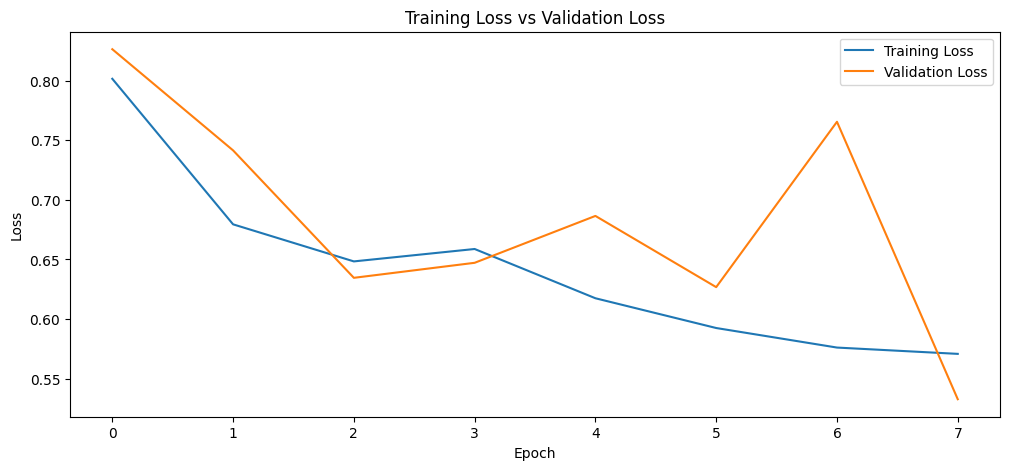

In [12]:
import matplotlib.pyplot as plt

# Plotting the curves
plt.figure(figsize=(12, 5))
plt.plot(train_loss_array, label='Training Loss')
plt.plot(valid_loss_array, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.show()

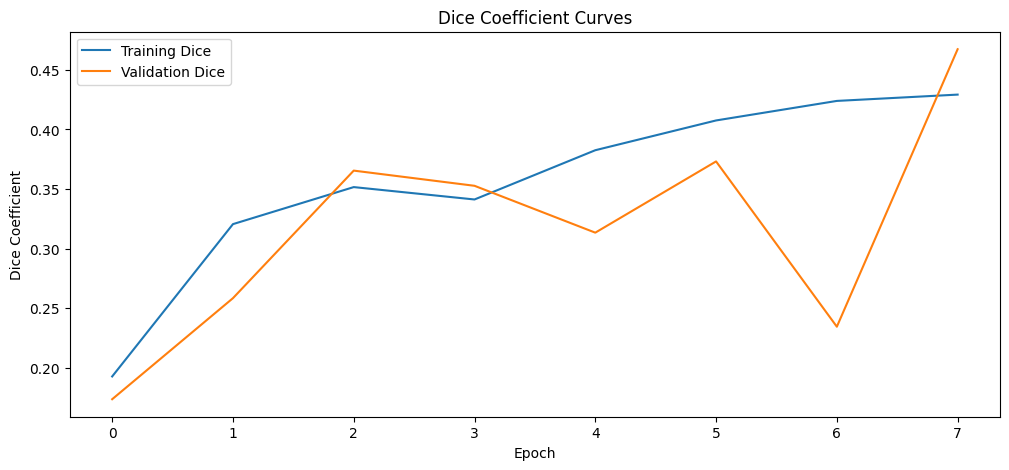

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(train_dice_array, label='Training Dice')
plt.plot(valid_dice_array, label='Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Curves')
plt.legend()
plt.show()

In [16]:
trained_model.load_state_dict(best_weights)
torch.save(trained_model.state_dict(), "/content/drive/My Drive/best_model_weights.pth")

Load Network

In [17]:
def load_model(model, model_path):
    """
    Load a saved model from the specified path.

    Args:
    - model: The model architecture to load the parameters into.
    - model_path: The path to the saved model file.

    Returns:
    - loaded_model: The loaded model.
    """
    loaded_model = model
    loaded_model.load_state_dict(torch.load(model_path))
    return loaded_model


In [18]:
# Load the saved model
loaded_model = load_model(UNet(in_channels=3, out_channels=1), "/content/drive/My Drive/best_model_weights.pth")

# Move the loaded model to the GPU if available
loaded_model = loaded_model.to(device)

# Set the loaded model to evaluation mode
loaded_model.eval()

# Now you can use the loaded model for inference
# For example, you can pass input images through the model to get predictions


UNet(
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down3): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2

Testing Using Loaded network

In [19]:
# Assuming you have already loaded the model using the load_model function

# Define a function to evaluate the model on the test dataset
# Define a function to evaluate the model on the test dataset
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc='Testing'):
            images, masks = images.to(device), masks.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item() * images.size(0)
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

# Load the test dataset
test_dataset = BreastCancerDataset(root_dir=root_dir, transform=transform, mask_transform=mask_transform, split='test')
test_loader = DataLoader(test_dataset, batch_size=16)

# Define the loss function (assuming you're still using dice loss)
criterion = dice_loss

# Evaluate the loaded model on the test dataset
evaluate_model(loaded_model, test_loader, criterion, device)


Testing: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

Test Loss: 0.5500


Accuracy without using loaded network

In [20]:
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    predictions = []
    targets = []
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            predictions.append(outputs.cpu())
            targets.append(masks.cpu())

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)

    return predictions, targets


In [21]:
def dice_coefficient(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice


In [22]:
def compute_accuracy(predictions, targets, threshold=0.5):
    predictions_binary = (predictions > threshold).float()
    accuracy = dice_coefficient(predictions_binary, targets)
    return accuracy


In [23]:
predictions, targets = test(trained_model, test_loader)
accuracy = compute_accuracy(predictions, targets)
print(f"--------Test Accuracy---------: {accuracy}")


Testing: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

--------Test Accuracy---------: 0.44485917687416077


Dice Score for test

Testing: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


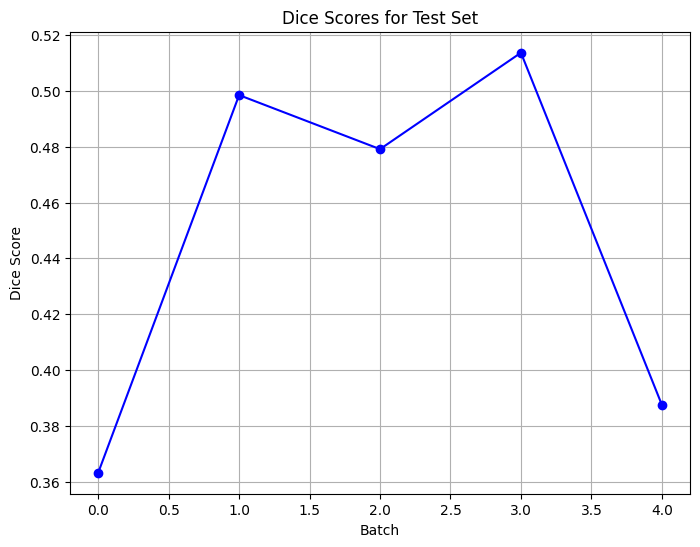

In [24]:
def test(model, test_loader):
    model.eval()
    dice_scores = []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc='Testing'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()

            # Calculate Dice score
            intersection = torch.sum(pred_masks * masks)
            union = torch.sum(pred_masks) + torch.sum(masks)
            dice = (2. * intersection) / (union + 1e-8)  # Add a small epsilon to avoid division by zero
            dice_scores.append(dice.item())

    return dice_scores

# Calculate Dice scores for the test set
test_dice_scores = test(trained_model, test_loader)

# Plotting Dice scores
plt.figure(figsize=(8, 6))
plt.plot(test_dice_scores, marker='o', linestyle='-', color='b')
plt.title('Dice Scores for Test Set')
plt.xlabel('Batch')
plt.ylabel('Dice Score')
plt.grid(True)
plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_sample_images(model, test_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), num_samples=5):
    model.eval()
    model.to(device)  # Move model to GPU if available
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i == num_samples:
                break
            images = images.to(device)  # Move images to GPU
            masks = masks.to(device)  # Move masks to GPU
            outputs = model(images)
            outputs = outputs.detach().cpu().numpy()  # Move outputs to CPU for numpy conversion
            masks = masks.detach().cpu().numpy()  # Move masks to CPU for numpy conversion
            for j in range(images.shape[0]):
                plt.figure(figsize=(5, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(np.transpose(images[j].cpu().numpy(), (1, 2, 0)))  # Move images to CPU for plotting
                plt.title('Input Image')
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(np.squeeze(outputs[j]), cmap='gray')
                plt.title('Predicted Mask')
                plt.axis('off')
                plt.show()

# Example usage:
# plot_sample_images(model, test_loader)


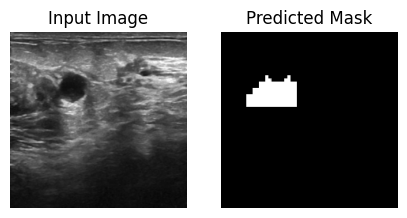

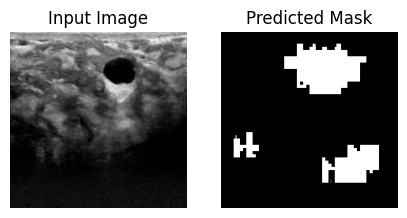

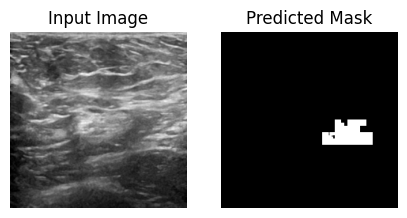

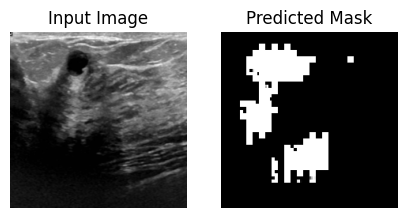

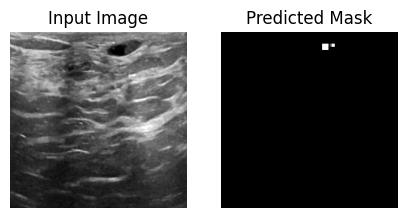

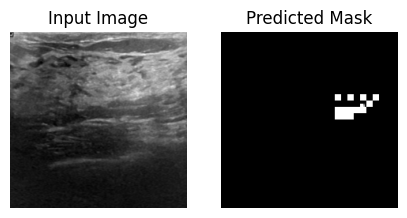

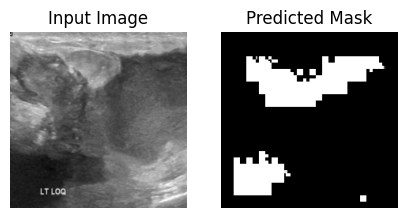

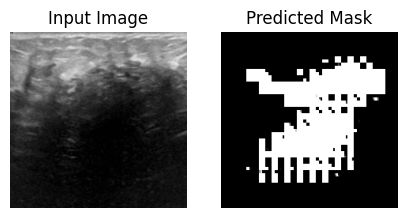

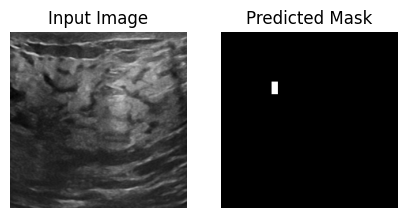

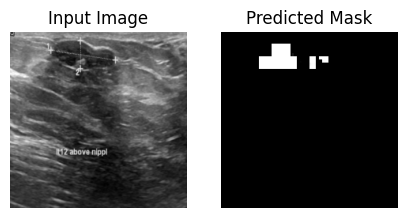

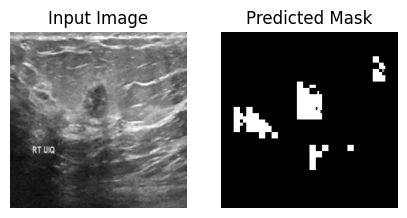

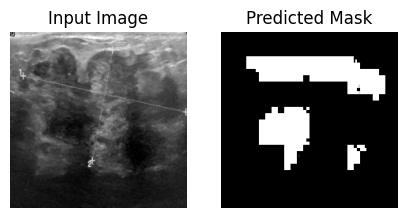

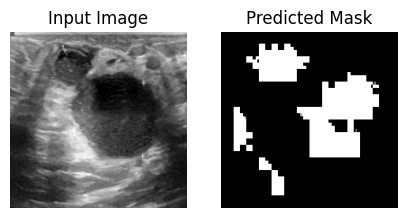

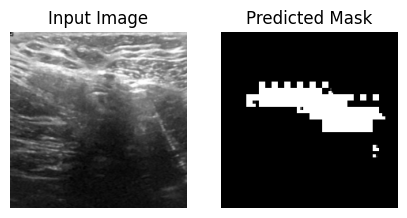

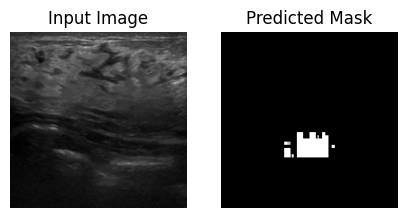

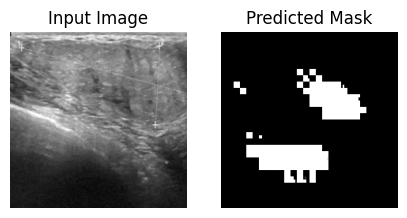

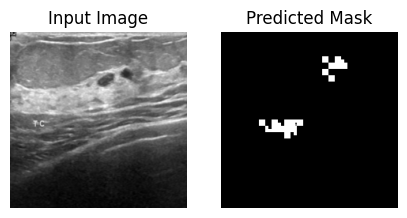

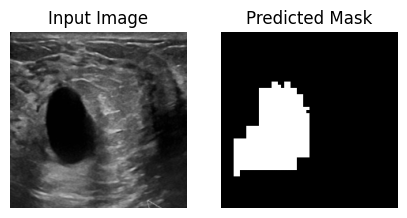

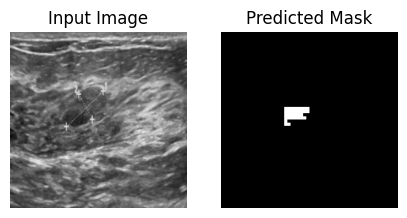

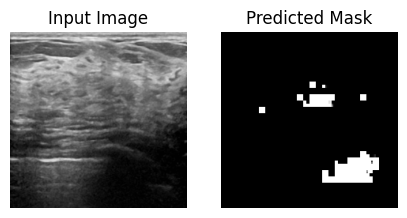

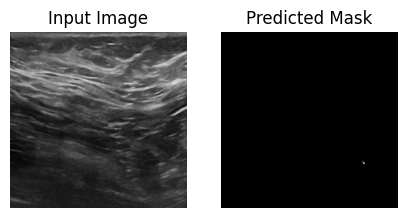

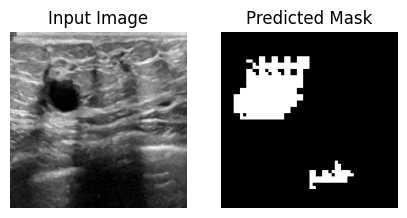

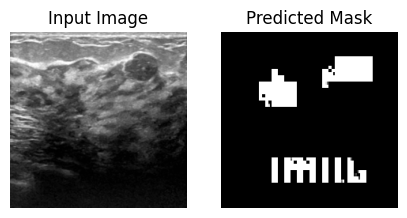

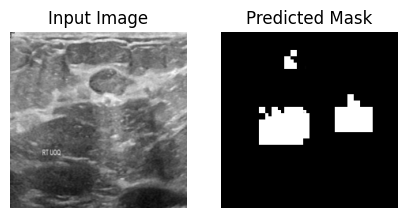

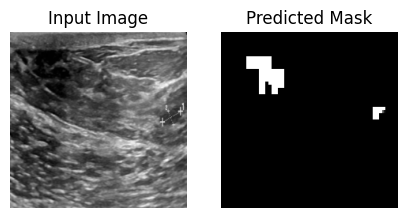

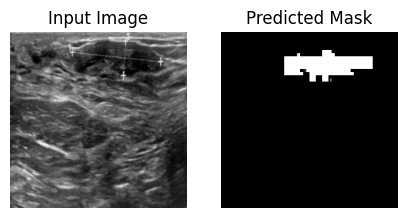

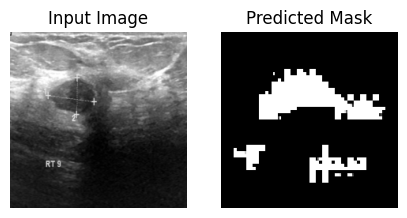

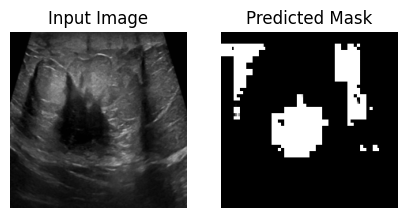

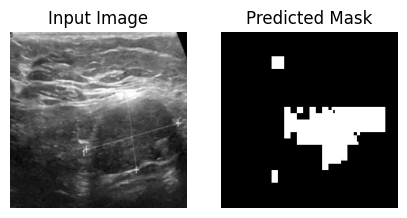

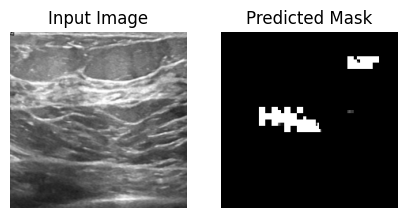

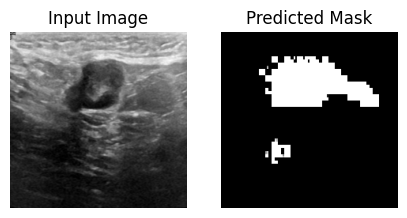

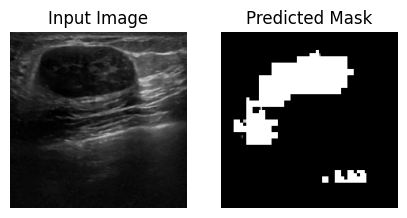

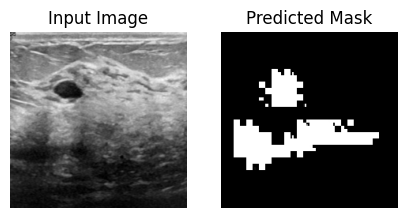

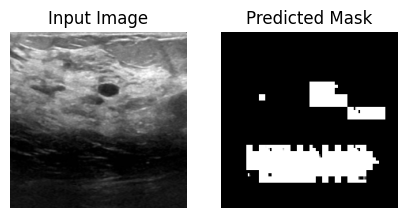

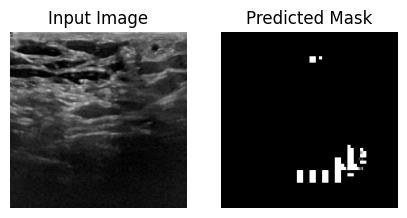

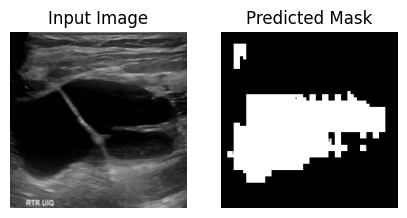

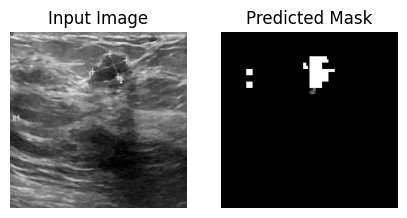

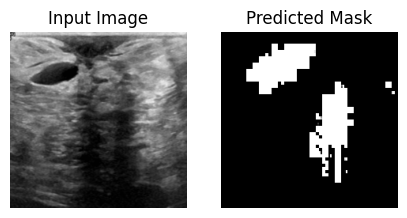

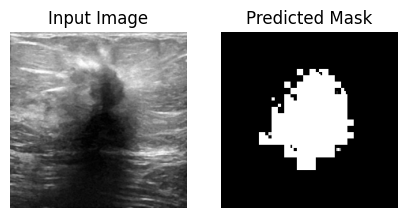

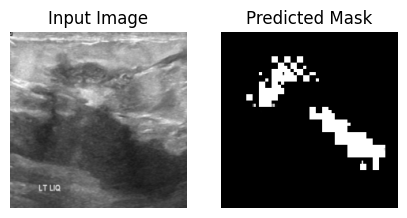

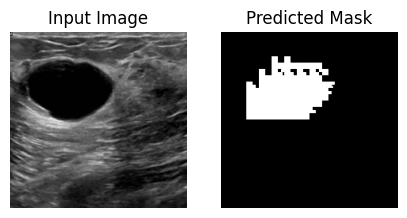

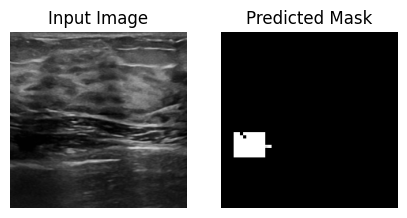

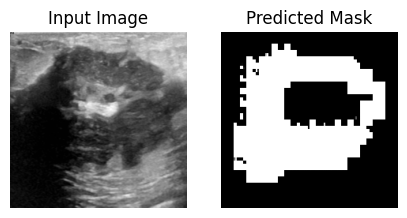

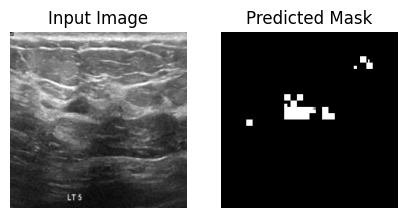

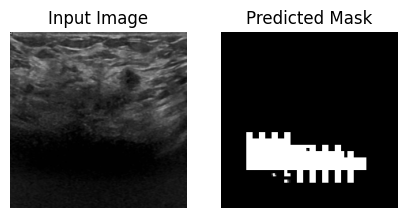

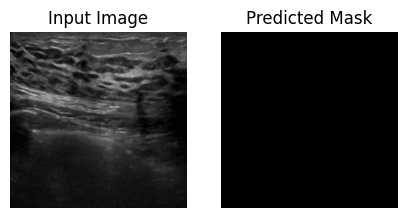

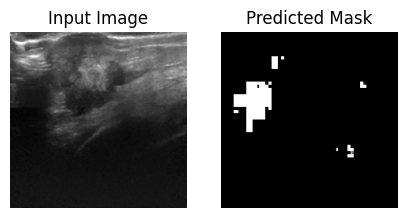

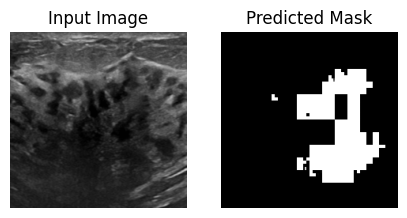

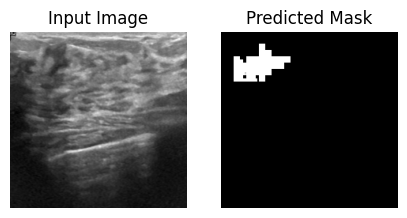

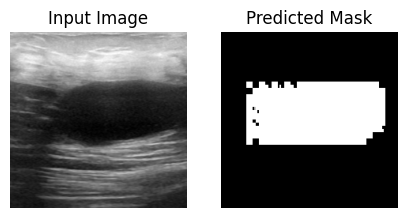

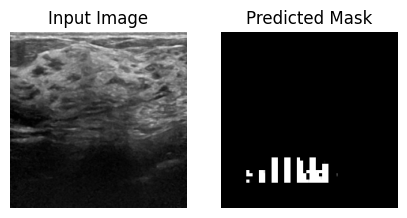

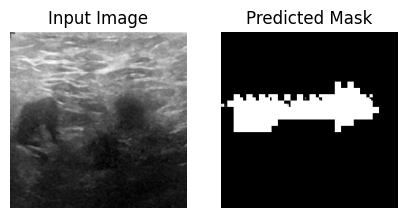

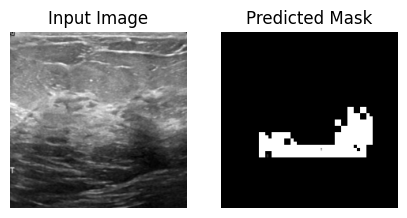

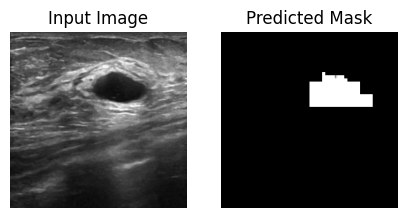

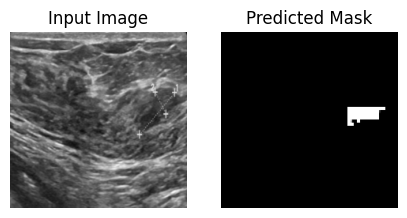

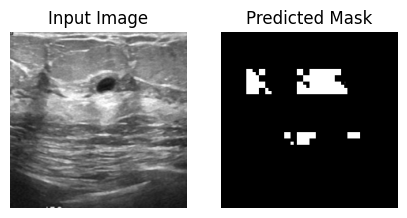

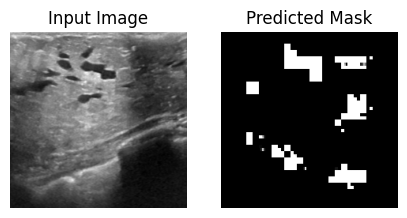

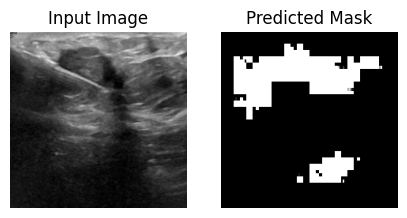

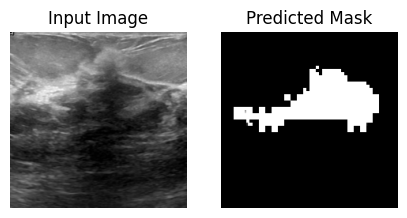

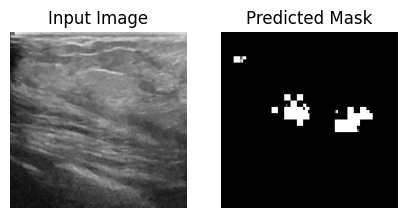

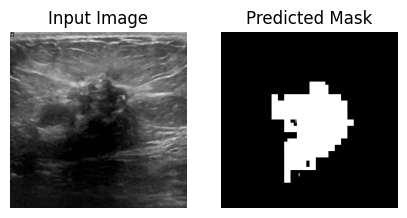

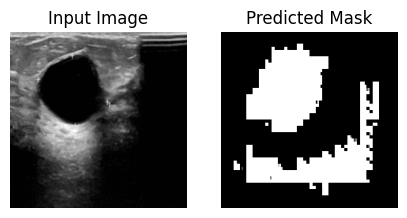

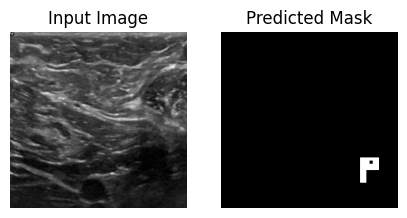

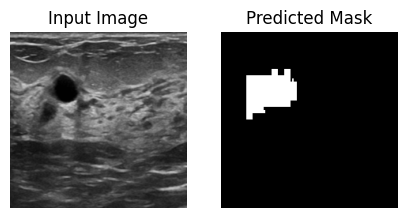

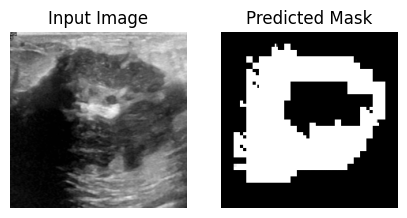

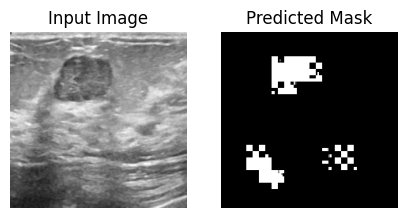

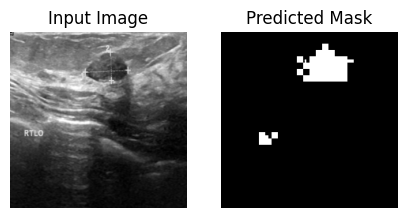

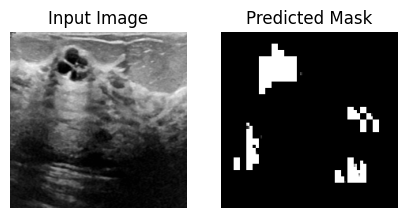

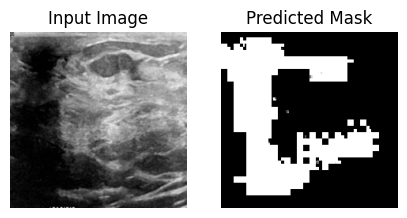

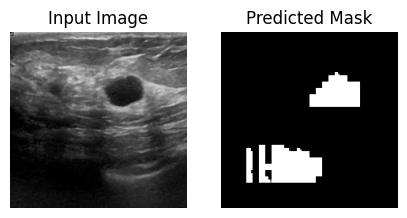

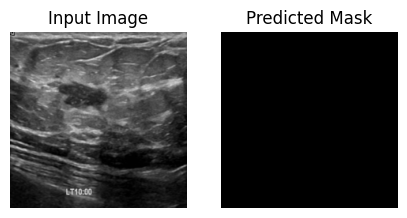

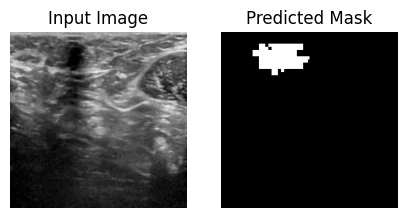

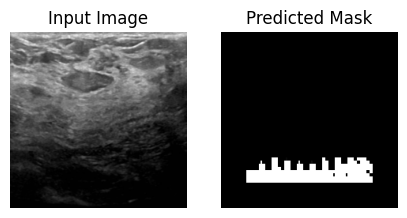

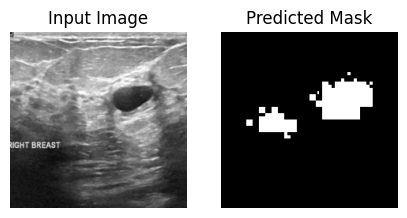

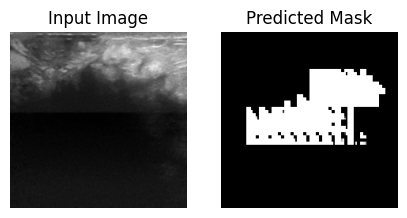

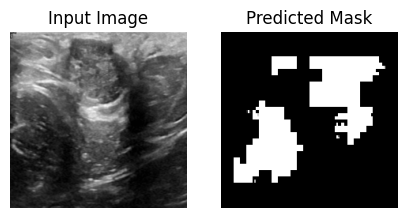

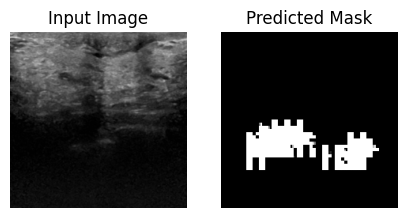

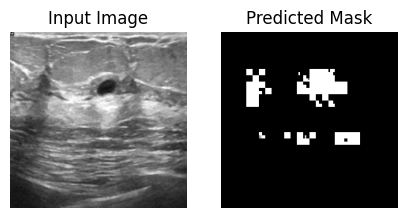

In [26]:
# Visualize sample images and predictions
plot_sample_images(trained_model, test_loader)


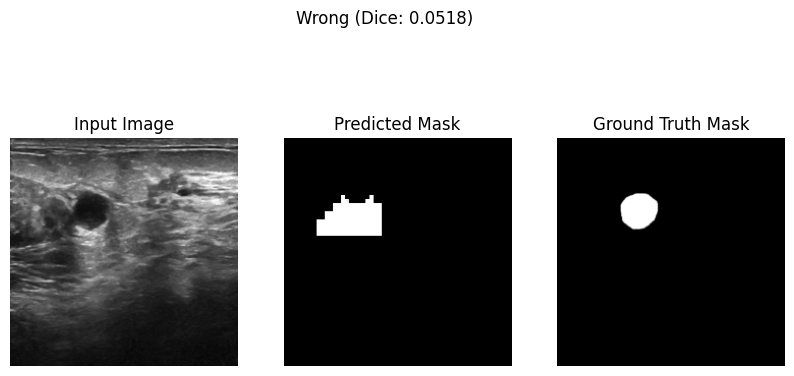

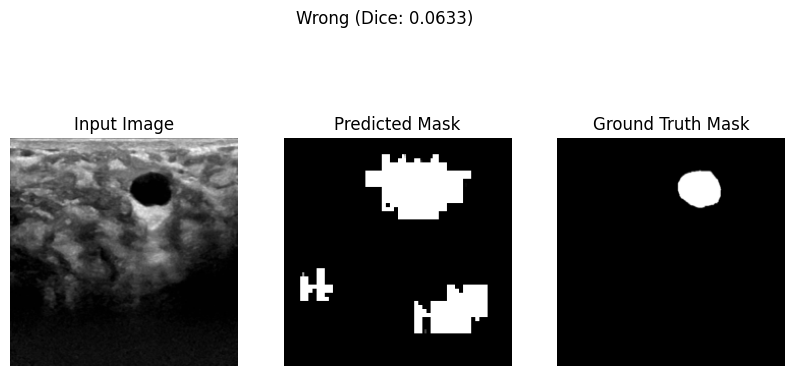

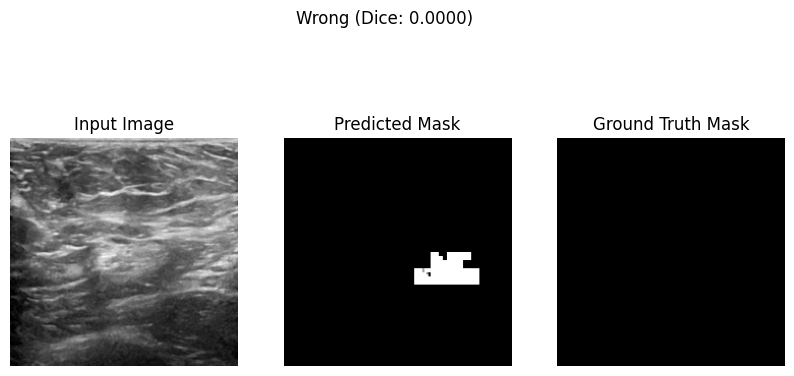

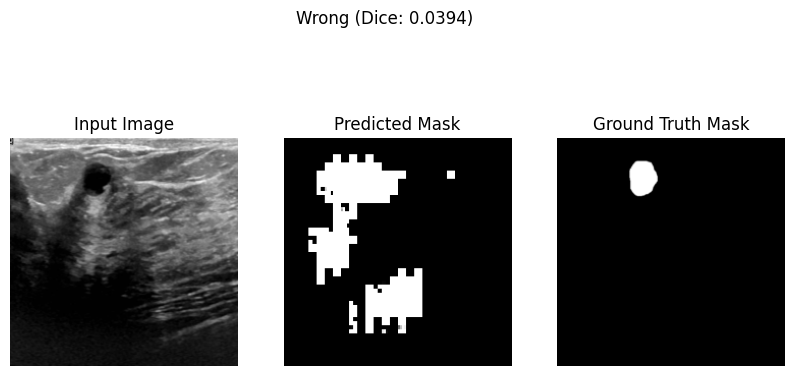

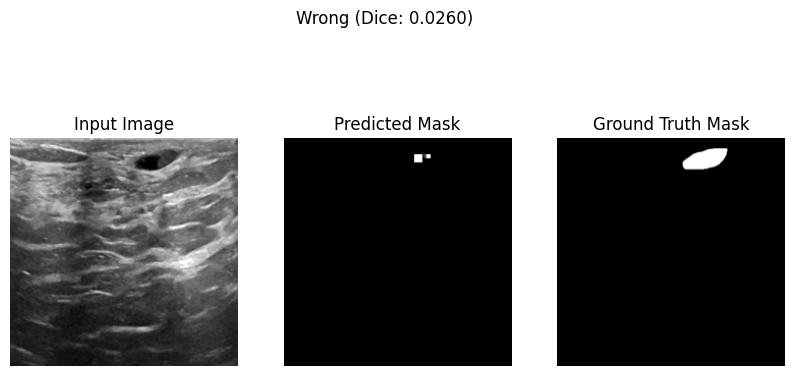

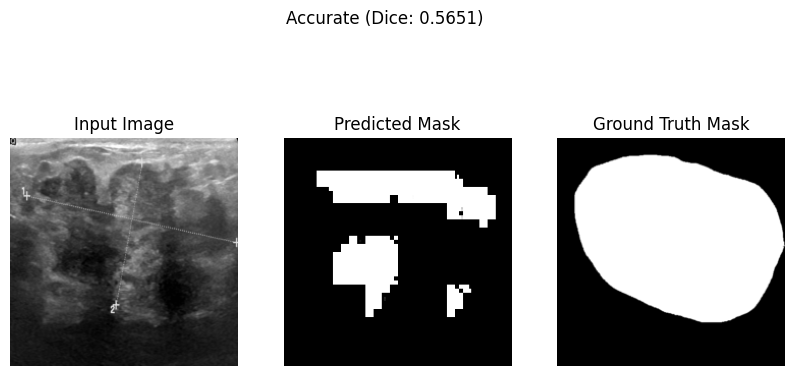

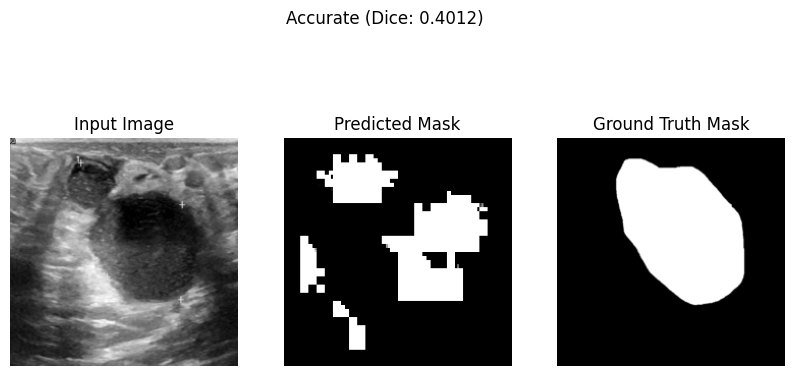

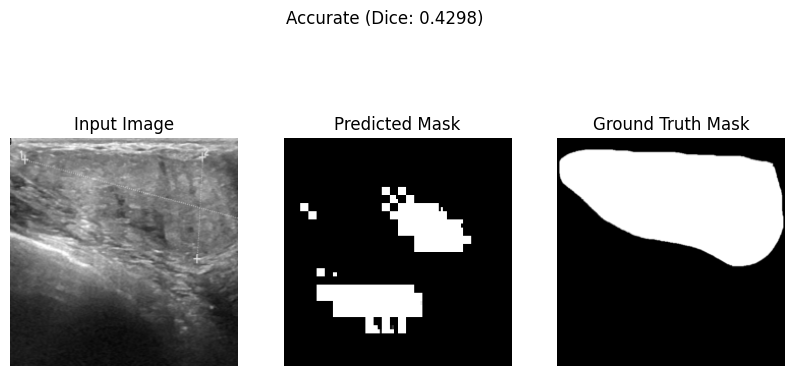

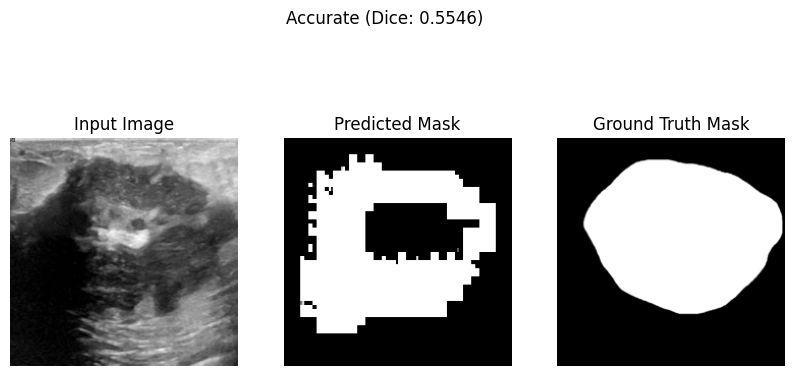

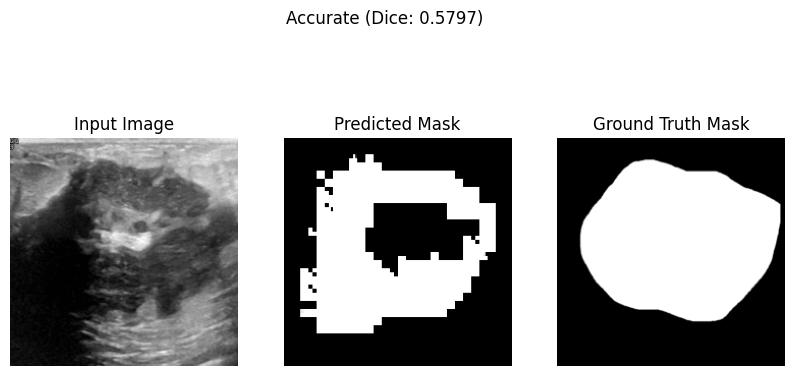

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

def plot_sample_images(model, test_loader, threshold=0.4, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), num_samples=5):
    model.eval()
    model.to(device)  # Move model to GPU if available
    with torch.no_grad():
        accurate_count = 0
        wrong_count = 0
        for i, (images, masks) in enumerate(test_loader):
            if accurate_count >= 5 and wrong_count >= 5:
                break
            images = images.to(device)  # Move images to GPU
            masks = masks.to(device)  # Move masks to GPU
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            for j in range(images.shape[0]):
                dice_score = dice_coefficient(masks[j], outputs[j])
                if dice_score >= threshold and accurate_count < 5:
                    accurate_count += 1
                    visualize_prediction(images[j], outputs[j], masks[j], title=f'Accurate (Dice: {dice_score:.4f})')
                elif dice_score < threshold and wrong_count < 5:
                    wrong_count += 1
                    visualize_prediction(images[j], outputs[j], masks[j], title=f'Wrong (Dice: {dice_score:.4f})')
                if accurate_count >= 5 and wrong_count >= 5:
                    break

def visualize_prediction(image, output, mask, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    plt.title('Input Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(output.cpu().numpy()), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(mask.cpu().numpy()), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Example usage:
plot_sample_images(model, test_loader, threshold=0.4)


In [28]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Step 1: Extract Encoder Output
def extract_encoder_output(model, data_loader, device):
    encoder_output = []
    labels = []
    with torch.no_grad():
        model.eval()
        for images, _, labels_batch in data_loader:
            # Move images and labels to the same device as the model
            images = images.to(device)
            labels_batch = labels_batch.to(device)

            # Forward pass to get the encoder output
            outputs = model(images)
            encoder_output.append(outputs)
            labels.append(labels_batch)
    # Concatenate the encoder output and labels
    encoder_output = torch.cat(encoder_output, dim=0)
    labels = torch.cat(labels, dim=0)
    return encoder_output, labels

def apply_tsne(encoder_output):
    # Reshape encoder_output to 2D tensor
    batch_size, channels, height, width = encoder_output.shape
    encoder_output_flat = encoder_output.view(batch_size, -1)

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=50)  # You can adjust the number of components as needed
    encoder_output_pca = pca.fit_transform(encoder_output_flat.cpu())

    # Apply t-SNE on the reduced dimensionality data
    tsne = TSNE(n_components=2, random_state=0)
    tsne_representation = tsne.fit_transform(encoder_output_pca)

    # Move the tsne_representation tensor to CPU
    tsne_representation = torch.tensor(tsne_representation)  # Convert to PyTorch tensor
    return tsne_representation




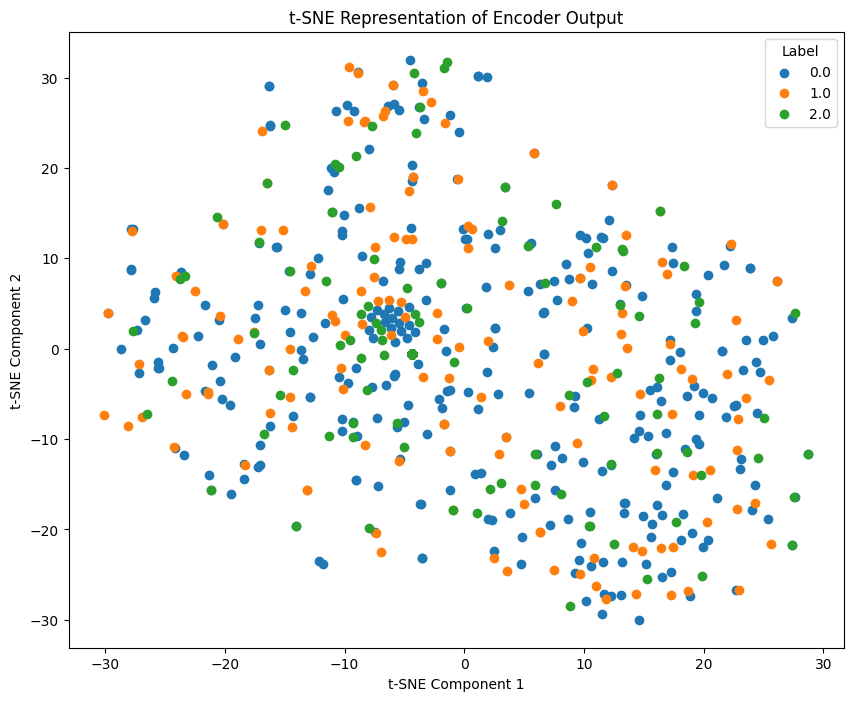

In [29]:

# Step 3: Plot the t-SNE Representation
def plot_tsne_representation(tsne_representation, labels):
    plt.figure(figsize=(10, 8))
    for label in torch.unique(labels):
        indices = (labels == label).nonzero().squeeze().cpu()  # Move indices to CPU
        plt.scatter(tsne_representation[indices, 0], tsne_representation[indices, 1], label=label.item())
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Representation of Encoder Output')
    plt.legend(title='Label')
    plt.show()



# Assuming you have `train_loader` defined for your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose device
encoder_output, labels = extract_encoder_output(model, train_loader, device)
tsne_representation = apply_tsne(encoder_output)
plot_tsne_representation(tsne_representation, labels)

Runtime testing


Enter the path to the image: /content/drive/MyDrive/Colab Notebooks/test.png


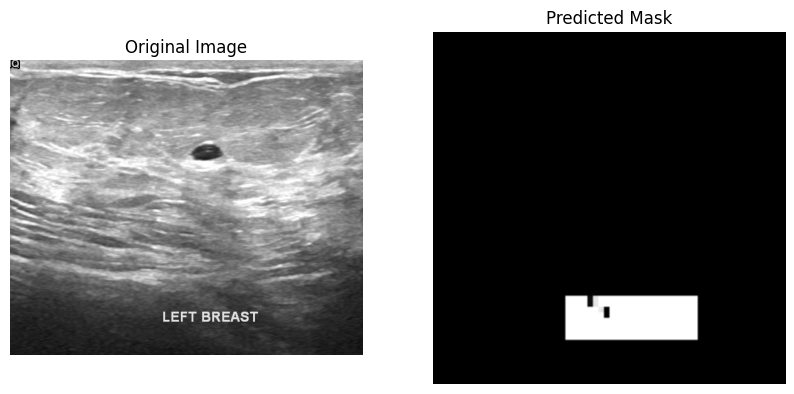

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    """
    Preprocesses the input image.
    Args:
        image_path (str): Path to the input image.
    Returns:
        torch.Tensor: Preprocessed image tensor.
    """
    image = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB mode
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension
 # Add batch dimension

def predict_mask(model, image_path):
    """
    Predicts the mask for the input image.
    Args:
        model (torch.nn.Module): Trained UNet model.
        image_path (str): Path to the input image.
    Returns:
        numpy.ndarray: Predicted mask array.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
    model.eval()  # Set the model to evaluation mode

    # Preprocess the input image
    image_tensor = preprocess_image(image_path).to(device)

    # Predict the mask
    with torch.no_grad():
        mask_pred = model(image_tensor)

    return mask_pred.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU

def plot_mask_prediction(image_path, mask_pred):
    """
    Plots the original image and the predicted mask.
    Args:
        image_path (str): Path to the input image.
        mask_pred (numpy.ndarray): Predicted mask.
    """
    image = Image.open(image_path)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_pred, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

def runtime_testing(model):
    """
    Performs runtime testing by taking an image path from the user, predicting the mask for the specified image, and plotting the results.
    Args:
        model (torch.nn.Module): Trained UNet model.
    """
    # Get the image path from the user
    image_path = input("Enter the path to the image: ")

    # Predict the mask
    mask_pred = predict_mask(model, image_path)

    # Plot the original image and predicted mask
    plot_mask_prediction(image_path, mask_pred)

# Example usage:
runtime_testing(loaded_model)
# Example usage:
# image_path ="/content/drive/MyDrive/Colab Notebooks/test.png"
# runtime_testing(loaded_model, image_path)  # Assuming 'loaded_model' is the trained UNet model  # Assuming 'loaded_model' is the trained UNet model
